In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

First, determine samples to use and gender of the samples. Uses Vasili's cov files.

In [2]:
cov_summaries = glob.glob("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Gorilla_gorilla_gorilla/cov/*")
df_l = []
for p in cov_summaries:
    df = pd.read_csv(p, sep="\t", names=["Name", "Contig", "start", "end", "length", "?", "coverage"])
    df["ID"] = p.split("/")[-1].split(".")[0]
    df_l.append(df)
df_cov = pd.concat(df_l)

In [3]:
df_cov["Contig_type"] = ["chrX" if x == "postPAR1" else "non-X" for x in df_cov.Name]
df_group = df_cov.groupby(["ID", "Contig_type"])["coverage"].median().reset_index()
non_X = df_group.loc[df_group.Contig_type == "non-X"]
df_cov["aut_cov"] = df_cov.ID.map(dict(zip(non_X.ID, non_X.coverage)))
df_cov["relative_cov"] = df_cov.coverage/df_cov.aut_cov

Use this df to create two sample cohorts, male and female.

In [4]:
df_x_only = df_cov.loc[df_cov.Contig_type == "chrX"]
df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]

/tmp/60694610/ipykernel_3969112/1432902879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]


In [5]:
ds = sg.load_dataset("../data/Gorilla_gorilla_gorilla")
ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(dict(zip(df_x_only.ID,df_x_only.Sex
                                                                              ))), dims="samples")

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
pd.Series(ds["variant_contig"]).unique() #unique or value_counts to determine contigs with data in them.

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int8)

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [7]:
missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=0).values/ds.call_genotype_mask[:,:,0].count(axis=0).values

In [8]:
missing_rate

array([0.02428184, 0.04952445, 0.08810716, 0.01017536, 0.0296555 ,
       0.04577904, 0.03799798, 0.2212559 , 0.00830614, 0.02570014,
       0.03482825, 0.02027905, 0.01212354, 0.03341797, 0.02960043,
       0.03397288, 0.00821925, 0.01065972, 0.01137621, 0.15283128,
       0.14081187, 0.15341871, 0.14400634, 0.28036693, 0.0865633 ,
       0.17309557, 0.05354975, 0.04463512, 0.12671107, 0.12070549,
       0.14086508, 0.03797301, 0.24062609, 0.14940157, 0.2069391 ,
       0.19717692, 0.24655475, 0.17560737, 0.24488276, 0.49461013,
       0.51011339, 0.46113639, 0.25920198, 0.23596314, 0.20020986,
       0.30358122])

[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

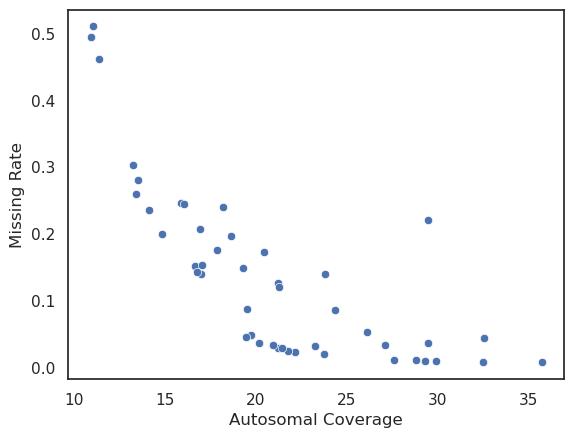

In [9]:
g = sns.scatterplot(y=missing_rate,
                x=df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].sort_values(by="ID").aut_cov)
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [10]:
test_df = pd.DataFrame({"Missing": missing_rate,
               "Aut_cov": df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].sort_values(by="ID").aut_cov,
             "ID": ds.sample_id.values}).sort_values(by="Aut_cov")

In [11]:
test_df["Seq_line"] = ["PD" if x[:1]=="P" else "SAMN" for x in test_df.ID]

[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

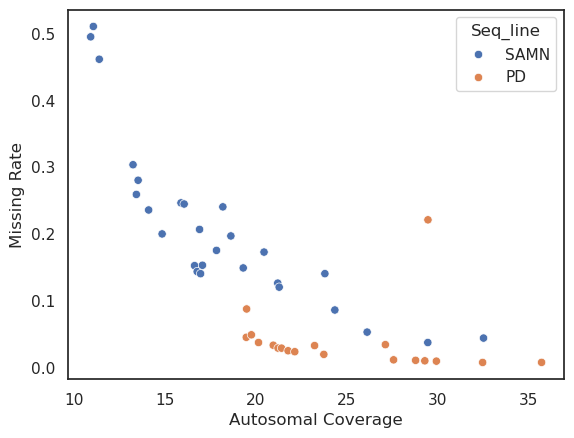

In [12]:
g = sns.scatterplot(test_df, y="Missing", x="Aut_cov", hue="Seq_line")
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [13]:
# Step to handle my issues - remove empty contigs, that is contigs without any variants.
dstest = ds.sel(contigs=pd.Series(ds["variant_contig"]).unique())
IDs_to_keep = df_x_only.loc[df_x_only.aut_cov >= 20].ID
df_i_ID = pd.DataFrame({"ds_index": ds.samples, "ID": ds.sample_id})
dstest = dstest.sel(samples=df_i_ID.loc[df_i_ID.ID.isin(IDs_to_keep)].ds_index.values)

In [14]:
dstest

<xarray.Dataset> Size: 3GB
Dimensions:               (variants: 21463034, samples: 24, ploidy: 2,
                           contigs: 24, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 515MB dask.array<chunksize=(1000, 24), meta=np.ndarray>
    contig_id             (contigs) object 192B dask.array<chunksize=(24,), meta=np.ndarray>
    contig_length         (contigs) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [15]:
# Going to use 10000 position windows as filtering is not that easy without a coverage map.
window_size = 10000
ds_w = sg.window_by_position(dstest, size=window_size)
ds_d = sg.diversity(ds_w) # It crashes on very large windows, but works in the 1k-10k range.

In [16]:
# Note how I generate a new coordinate to filter/plot by, and make sure to add the relevant dimensions to it.
window_starts_bp = pd.DataFrame({"window_contig":ds_d.window_contig}).groupby("window_contig").cumcount().values*window_size
ds_d["w_s_bp"] = (["windows"], window_starts_bp)
ds_d

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 346749, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 6MB dask.array<chunksize=(569, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 3MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 3MB 0 0 0 ... 21463033 21463033
    window_stop           (windows) int64 3MB 0 0 0 ... 21463033 21463034
    ...                    ...
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 3MB 0 10000 ... 177530000 177540000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [17]:
ds_d

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 346749, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 6MB dask.array<chunksize=(569, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 3MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 3MB 0 0 0 ... 21463033 21463033
    window_stop           (windows) int64 3MB 0 0 0 ... 21463033 21463034
    ...                    ...
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 3MB 0 10000 ... 177530000 177540000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [18]:
ds_vi = ds_d.set_index(variants=("variant_contig", "variant_position"))

In [19]:
div_stats_x = ds_vi.sel(variant_contig = 23)["stat_diversity"].values

[(-1.0, 75.0), Text(0.5, 1.0, 'Diversity per 10k')]

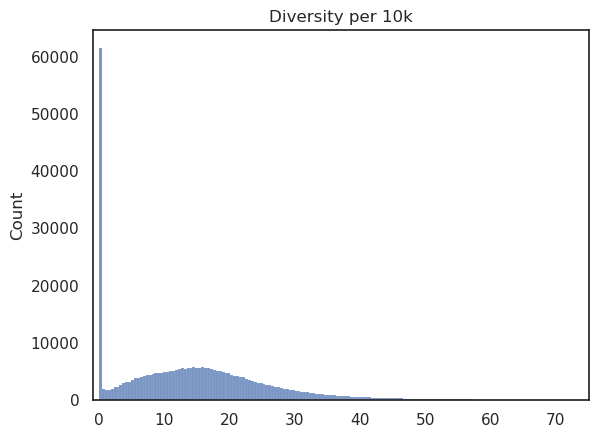

In [20]:
g = sns.histplot(div_stats_x[:,0])
g.set(xlim=(-1, 75), title="Diversity per 10k")

<Axes: ylabel='Count'>

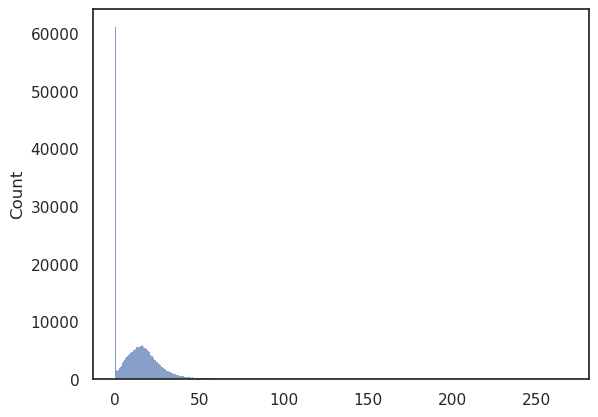

In [21]:
sns.histplot(div_stats_x[:,1])

In [22]:
ds_vi

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 346749, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
  * variants              (variants) object 172MB MultiIndex
  * variant_contig        (variants) int8 21MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 86MB 363782 363788 ... 177542837
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 6MB dask.array<chunksize=(569, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 3MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 3MB 0 0 0 ... 21463033 21463033
    window_stop           (windows) int64 3MB 0 0 0 ... 21463033 21463034
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 3MB 0 10000 ... 177530000 177540000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [23]:
np.nanmean(div_stats_x[:,1]), np.nanmean(div_stats_x[:,0]) # Females have a marginally higher diversity, but very similar

(14.4839175417598, 14.263904442762103)

In [24]:
# Code from the sgkit reference to find the variants that are in each window.
size_l = pd.Series([j-i for i, j in zip(ds_d.window_start[:].values,
                             ds_d.window_stop[:].values)])
# Very slow, but I do not need to extract the exact variants. Difference between index start and end is enough.
# And this is quick.

[Text(0.5, 1.0, 'Variants per window')]

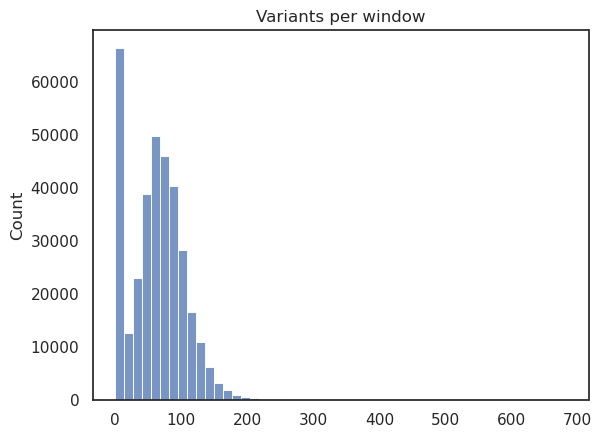

In [25]:
g = sns.histplot(size_l, bins=50)
g.set(title="Variants per window")

In [26]:
size_l.mean(), size_l.median(), size_l.quantile(0.2)

(61.897897326308076, 64.0, 18.0)

Subsetting to only use windows with at least 10 sites.
Determining whether diversity correlation is similar on chrX and autosomes across male/females.

In [27]:
ds_sites = ds_d.sel(windows = (size_l >= 10))
ds_sites = ds_sites.set_index(variants=("variant_contig", "variant_position"))

In [28]:
ds_sites

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 282387, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
  * variants              (variants) object 172MB MultiIndex
  * variant_contig        (variants) int8 21MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 86MB 363782 363788 ... 177542837
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 5MB dask.array<chunksize=(16, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 2MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 2MB 0 36 63 ... 21462937 21462982
    window_stop           (windows) int64 2MB 14 53 82 ... 21462959 21462992
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 2MB 360000 4490000 ... 175550000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Diversity comparison before and after this filter.

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

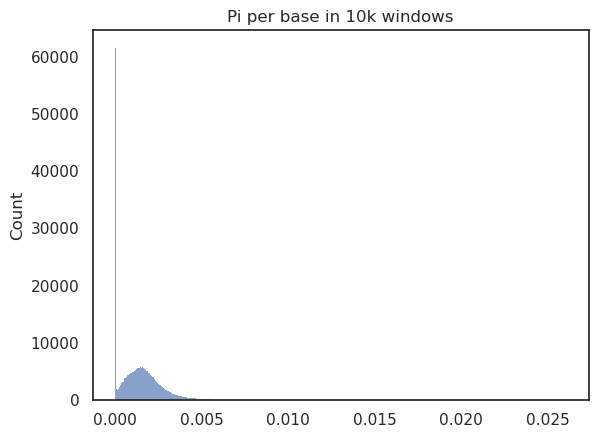

In [29]:
g = sns.histplot(ds_d["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

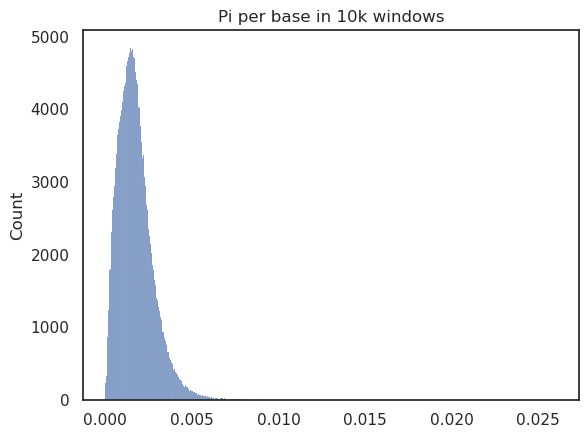

In [30]:
g = sns.histplot(ds_sites["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

Checking correlation between maleX and femaleX. The number of windows are correct (I would imagine), but the positions are odd. It's index positions.

In [31]:
ds_sitesX = ds_sites.sel(windows=(ds_sites.window_contig == 23))

In [32]:
ds_sitesX

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 14414, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
  * variants              (variants) object 172MB MultiIndex
  * variant_contig        (variants) int8 21MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 86MB 363782 363788 ... 177542837
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 231kB dask.array<chunksize=(16, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 115kB 23 23 23 23 23 ... 23 23 23 23
    window_start          (windows) int64 115kB 20797007 20797025 ... 21462982
    window_stop           (windows) int64 115kB 20797025 20797120 ... 21462992
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 115kB 9590000 9600000 ... 175550000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [33]:
len(ds_sitesX.window_contig)

14414

[Text(0.5, 1.0, 'Male chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

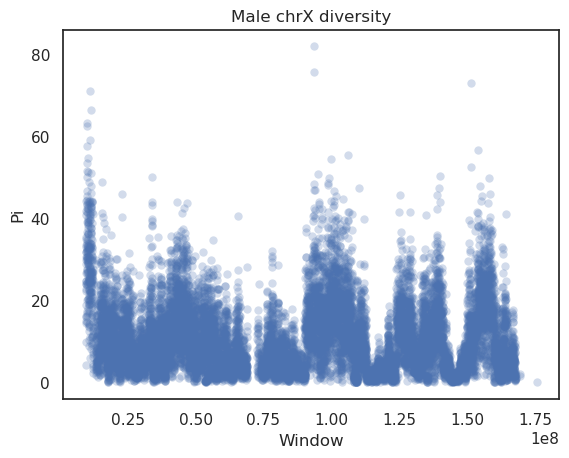

In [34]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,0], alpha=0.25, linewidth=0)
g.set(title="Male chrX diversity", ylabel="Pi", xlabel="Window")

[Text(0.5, 1.0, 'Female chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

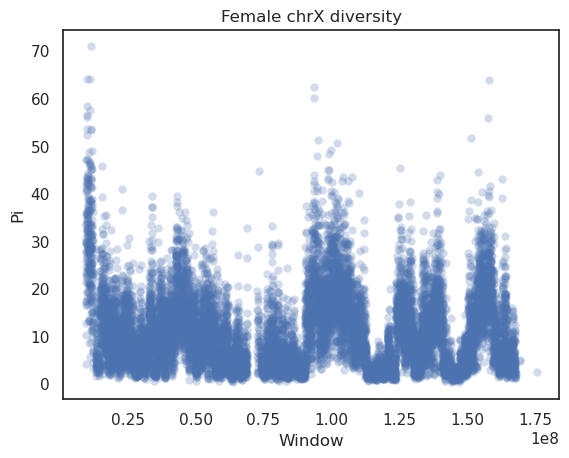

In [35]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,1], alpha=0.25, linewidth=0)
g.set(title="Female chrX diversity", ylabel="Pi", xlabel="Window")

Runs of low diversity.

In [36]:
import itertools
diversity_df = pd.DataFrame({"window_start": ds_sitesX.w_s_bp, "diversity": ds_sitesX.stat_diversity[:,1]})
diversity_df["low_cut"] = diversity_df.diversity < np.quantile(ds_sitesX.stat_diversity[:,1].values, 0.5)
diversity_df["low_streak"] = [i for k, g in itertools.groupby(diversity_df["low_cut"]) for i in range(len(list(g)))]


[Text(0.5, 1.0, 'Female chrX low diversity runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

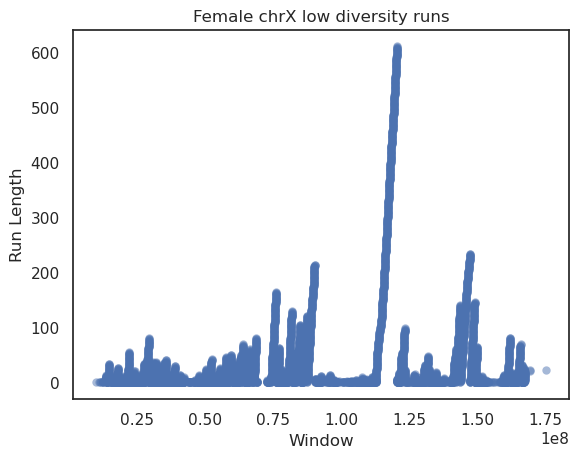

In [37]:
g = sns.scatterplot(diversity_df.loc[diversity_df.low_cut == True], x="window_start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Female chrX low diversity runs", ylabel="Run Length", xlabel="Window")

In [57]:
ds_sites4 = ds_sites.sel(windows=(ds_sites.window_contig == 3))

[Text(0.5, 1.0, 'Female chr4 low diversity runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

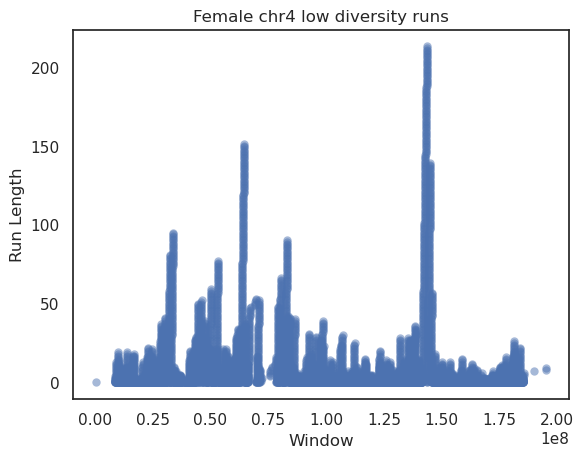

In [60]:
diversity_df = pd.DataFrame({"window_start": ds_sites4.w_s_bp, "diversity": ds_sites4.stat_diversity[:,1]})
diversity_df["low_cut"] = diversity_df.diversity < np.quantile(ds_sites4.stat_diversity[:,1].values, 0.5)
diversity_df["low_streak"] = [i for k, g in itertools.groupby(diversity_df["low_cut"]) for i in range(len(list(g)))]
g = sns.scatterplot(diversity_df.loc[diversity_df.low_cut == True], x="window_start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Female chr4 low diversity runs", ylabel="Run Length", xlabel="Window")

[Text(0.5, 1.0, 'Female chr4 low diversity runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

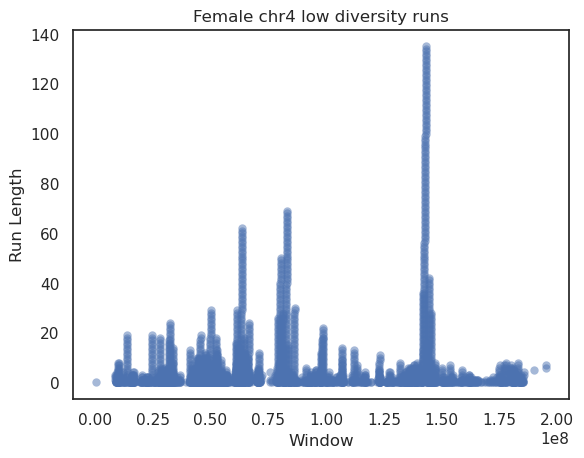

In [61]:
diversity_df = pd.DataFrame({"window_start": ds_sites4.w_s_bp, "diversity": ds_sites4.stat_diversity[:,1]})
diversity_df["low_cut"] = diversity_df.diversity < np.quantile(ds_sites4.stat_diversity[:,1].values, 0.2)
diversity_df["low_streak"] = [i for k, g in itertools.groupby(diversity_df["low_cut"]) for i in range(len(list(g)))]
g = sns.scatterplot(diversity_df.loc[diversity_df.low_cut == True], x="window_start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Female chr4 low diversity runs", ylabel="Run Length", xlabel="Window")

Garuds H.

In [39]:
ds_garud = sg.Garud_H(ds_sitesX)

[Text(0.5, 1.0, "Female chrX Garud's H12"),
 Text(0, 0.5, 'Percentage haplotypes'),
 Text(0.5, 0, 'Window')]

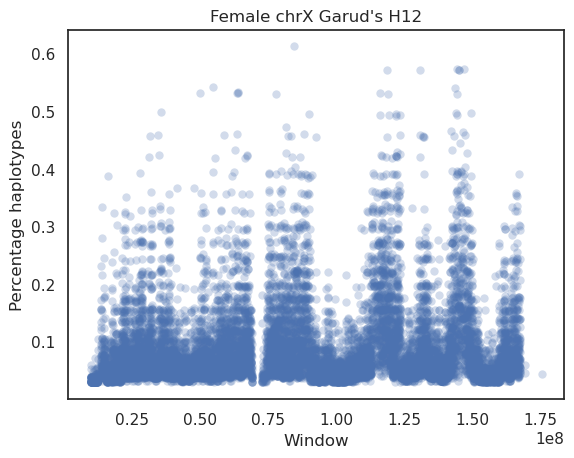

In [40]:
g = sns.scatterplot(x=ds_garud.w_s_bp[1:], y=ds_garud.stat_Garud_h12[:len(ds_garud.stat_Garud_h12)-1,1].values, alpha=0.25, linewidth=0)
g.set(title="Female chrX Garud's H12", ylabel="Percentage haplotypes", xlabel="Window")

In [41]:
ds_sites.sel(windows=(ds_sites.window_start <= 1000))

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 20, cohorts: 2, variants: 21463034,
                           alleles: 2, samples: 24, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 192B 0 3 4 6 7 8 ... 26 27 28 29 30 31
  * variants              (variants) object 172MB MultiIndex
  * variant_contig        (variants) int8 21MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 86MB 363782 363788 ... 177542837
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 320B dask.array<chunksize=(20, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 687MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 1GB dask.array<chunksize=(1000, 24, 2), meta=np.ndarray>
    window_contig         (windows) int64 160B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    window_start          (windows) int64 160B 0 36 63 97 ... 827 880 941 986
    window_stop           (windows) int64 160B 14 53 82 108 ... 880 941 986 1050
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 192B 1 1 0 1 1 1 1 1 ... 1 1 1 1 1 1 1
    w_s_bp                (windows) int64 160B 360000 4490000 ... 5680000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [42]:
ds_sites_aut = ds_sites.sel(windows=(ds_sites.window_contig != 23))

In [43]:
xr.corr(ds_sitesX.stat_diversity[:,1], ds_sitesX.stat_diversity[:,0]).values

array(0.89975867)

Brainstorm other statistics to present. Lets do some relatedness statistics.

In [44]:
c_chosen = 10
ds10 = dstest.sel(variants=(dstest.variant_contig == 10).compute())

<Axes: >

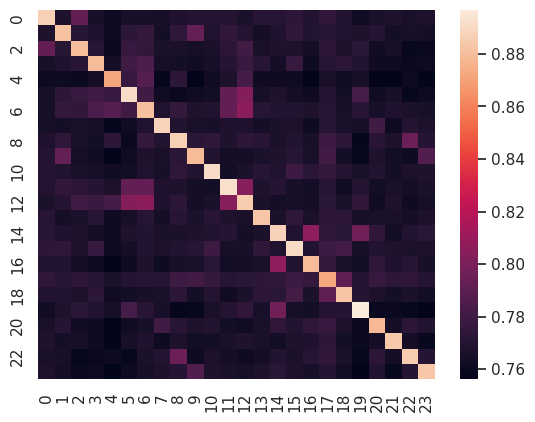

In [45]:
sns.heatmap(sg.identity_by_state(ds10)["stat_identity_by_state"].values)

In [46]:
ids_square = sg.identity_by_state(ds10)["stat_identity_by_state"].values

<Axes: ylabel='Count'>

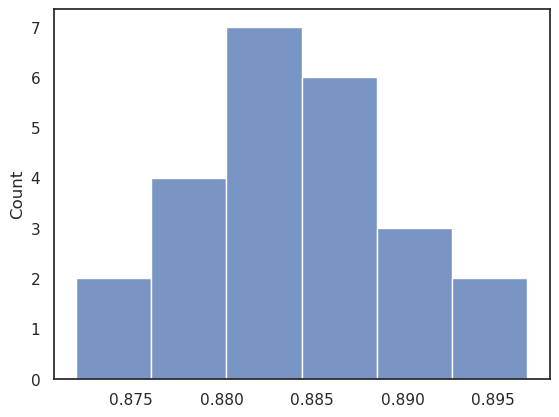

In [47]:
sns.histplot(ids_square.diagonal())

<Axes: ylabel='Count'>

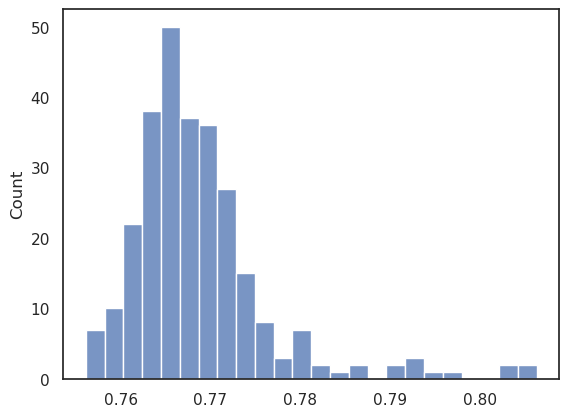

In [48]:
sns.histplot(ids_square[np.tril_indices(len(ids_square), -1)])

In [49]:
missing_rate = ds10.call_genotype_mask[:,:,1].sum(axis=1).values/ds10.call_genotype_mask[:,:,1].count(axis=1).values
ds10ss = ds10.isel(variants=(missing_rate == 0))

In [50]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")

<Axes: ylabel='Count'>

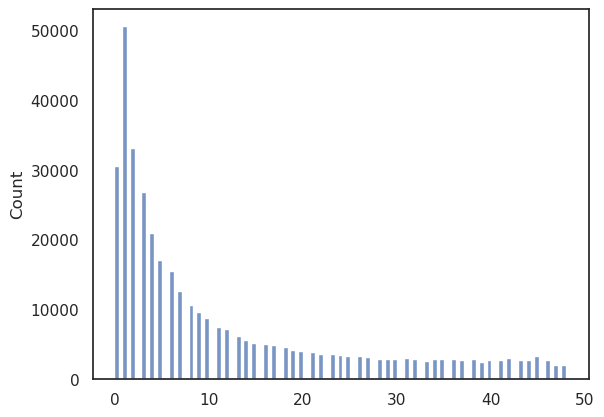

In [51]:
sns.histplot(ds10ss.call_dosage.sum(axis=1))

In [52]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")
ds10ss = ds10ss.isel(variants=((ds10ss.call_dosage.sum(axis=1).values >= 6)
                               & (ds10ss.call_dosage.sum(axis=1).values <= 42)))
ds10ss = sg.window_by_variant(ds10ss, size=100)
pruned_ds = sg.ld_prune(ds10ss)
pca10 = sg.pca(pruned_ds)

[Text(0.5, 0, 'PC1, Variance explained 0.08'),
 Text(0, 0.5, 'PC2, Variance explained 0.0633')]

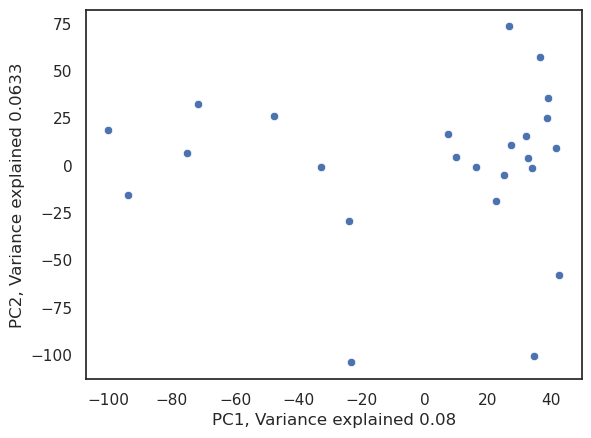

In [53]:
pcx = 0
pcy = 1
g =sns.scatterplot(x=pca10.sample_pca_projection[:,pcx], y=pca10.sample_pca_projection[:,pcy])
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcy].values))

In [54]:
pc_relate_matrix = sg.pc_relate(pca10, maf=0.1)["pc_relate_phi"].values

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/dask/array/core.py:3488: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


<Axes: >

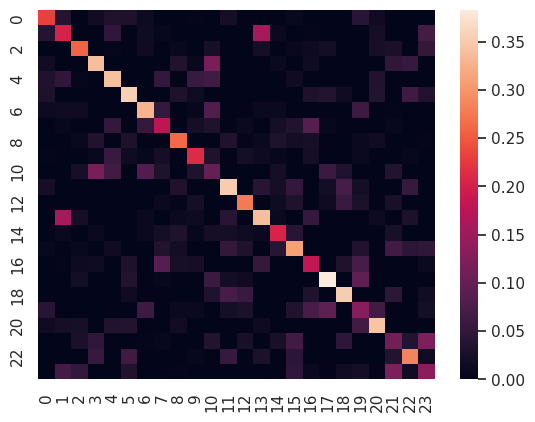

In [55]:
sns.heatmap(pc_relate_matrix.clip(min=0))
# Self should be 0.5, but is instead inferred to be 0.25-0.4 for the various individuals.

It should've calculated the self-kinship coefficient to be 0.5 on the diagonal, but instead it seems to be in the 0.25-0.4 ballpark.

In [ ]:
pc_relate_matrix

In [ ]:
ds_prep = pruned_ds.drop_dims(["windows"])
ds_prep["sample_cohort"] = xr.DataArray(range(len(ds_prep.sample_id)))
ds_prep = sg.window_by_genome(ds_prep)
fst_results = sg.Fst(ds_prep)
fst_results = fst_results["stat_Fst"].values
fst_results

In [ ]:
sns.clustermap(np.nan_to_num(fst_results)[0].clip(min=0))